In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from torch.optim import lr_scheduler

In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

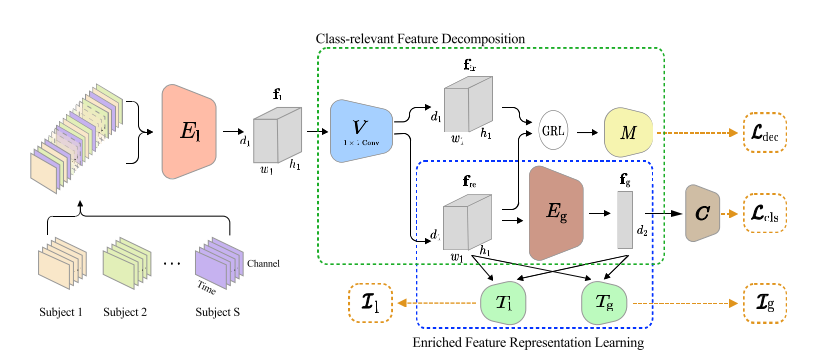

# Read Data

In [3]:
train_set = pd.read_csv("data/64_640data/train_set.csv",header=None).to_numpy()
train_label = pd.read_csv("data/64_640data/train_label.csv",header=None).to_numpy()
test_set = pd.read_csv("data/64_640data/test_set.csv",header=None).to_numpy()
test_label = pd.read_csv("data/64_640data/test_label.csv",header=None).to_numpy()

In [4]:
#delet first row data
train_set = train_set[1:]
train_label = train_label[1:]
test_set = test_set[1:]
test_label = test_label[1:]
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(1439, 40960) (1439, 1) (360, 40960) (360, 1)


In [5]:
train_set = train_set.reshape((-1,1,64,640))
test_set = test_set.reshape((-1,1,64,640))
train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)

In [6]:
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(1439, 1, 64, 640) (1439,) (360, 1, 64, 640) (360,)


In [7]:
train_set_tensor = Tensor(train_set) 
train_label_tensor = Tensor(train_label).type(torch.LongTensor)

train_dataset = TensorDataset(train_set_tensor,train_label_tensor) 
train_loader = DataLoader(train_dataset, batch_size=64) 

test_set_tensor = Tensor(test_set) 
test_label_tensor = Tensor(test_label).type(torch.LongTensor)

test_dataset = TensorDataset(test_set_tensor,test_label_tensor) 
test_loader = DataLoader(test_dataset, batch_size=64) 

# construct model

In [8]:
F1 = 8
D = 2
F2 = 16
drop_prob = 0.5

In [9]:
class Conv2dWithConstraint(nn.Conv2d):
    def __init__(self, *args, max_norm=1, **kwargs):
        self.max_norm = max_norm
        super(Conv2dWithConstraint, self).__init__(*args, **kwargs)
    def forward(self, x):
        self.weight.data = torch.renorm(self.weight.data, p=2, dim=0, maxnorm=self.max_norm)
        return super(Conv2dWithConstraint, self).forward(x)

In [10]:
class LocalEncoder_EEGNet(nn.Module):
    def __init__(self, fs, num_ch, num_time):
        super(LocalEncoder_EEGNet, self).__init__()
        self.c1 = nn.Conv2d(in_channels=1, out_channels=F1, kernel_size=(1, int(fs / 2)), stride=1, bias=False,
                            padding=(0, (int(fs / 2) // 2) - 1))  # []
        self.b1 = nn.BatchNorm2d(F1)
        self.c2 = Conv2dWithConstraint(in_channels=F1, out_channels=F1 * D, kernel_size=(num_ch, 1), stride=1,
                                       bias=False, groups=F1, padding=(0, 0), max_norm=1)
        self.b2 = nn.BatchNorm2d(F1 * D)
        self.p2 = nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4))
        self.d2 = nn.Dropout(drop_prob)

    def forward(self, input):
        h1 = self.b1(self.c1(input))
        h2 = self.d2(self.p2(F.elu(self.b2(self.c2(h1)))))
        return h2

In [11]:
# local_enc = LocalEncoder_EEGNet(fs=160, num_ch=64, num_time = 640)
# a = torch.randn((10,1,64,640))
# b = local_enc(a)
# b.shape

In [12]:
class Decomposer(nn.Module):
    def __init__(self, nfeat):
        super(Decomposer, self).__init__()
        self.nfeat = nfeat
        self.embed_layer = nn.Sequential(nn.Conv2d(nfeat, nfeat*2, kernel_size=1, bias=False),
                                         nn.BatchNorm2d(nfeat*2), nn.ELU(), nn.Dropout())

    def forward(self, x):
        embedded = self.embed_layer(x)
        #print(embedded.shape)
        rele, irre = torch.split(embedded, [int(self.nfeat), int(self.nfeat)], dim=1)

        return rele, irre

In [13]:
# decomposer = Decomposer(16)
# c, d = decomposer(b)
# print(c.shape,d.shape)

In [14]:
class GlobalEncoder_EEGNet(nn.Module):
    def __init__(self, num_ch, num_time, nfeatl):
        super(GlobalEncoder_EEGNet, self).__init__()
        self.c3 = nn.Conv2d(in_channels=nfeatl, out_channels=F1 * D, kernel_size=(1, 16), stride=1, bias=False,
                            groups=(nfeatl), padding=(0, 16 // 2))
        self.b3 = nn.BatchNorm2d(F1 * D)
        self.p3 = nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8))
        self.d3 = nn.Dropout(drop_prob)

    def forward(self, x):
        h3 = self.d3(self.p3(F.elu(self.b3(self.c3(x)))))
        h3_ = torch.flatten(h3, start_dim=1)
        return h3_


In [15]:
# global_enc = GlobalEncoder_EEGNet(64,640,16)
# e = global_enc(c)
# e.shape

In [16]:
class Classifier(nn.Module):
    def __init__(self, nfeatr):
        super(Classifier, self).__init__()
        self.dense1 = nn.Linear(nfeatr, 4)

    def forward(self, latent):
        out = self.dense1(latent)

        return out

In [17]:
# classifier = Classifier(320)
# f = classifier(e)
# f.shape

In [18]:
class GradReverse(torch.autograd.Function):
    """
    Extension of grad reverse layer
    """
    @staticmethod
    def forward(ctx, x, constant):
        ctx.constant = constant
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_output = grad_output.neg() * ctx.constant
        return grad_output, None

    def grad_reverse(x, constant):
        return GradReverse.apply(x, constant)

In [19]:
class MINE(nn.Module):
    def __init__(self, nfeatr, nfeati):
        super(MINE, self).__init__()
        self.fc1_x = nn.Linear(nfeatr, int(nfeatr/16))
        self.bn1_x = nn.BatchNorm1d(int(nfeatr/16))
        self.fc1_y = nn.Linear(nfeati, int(nfeati/16))
        self.bn1_y = nn.BatchNorm1d(int(nfeati/16))

        self.fc2 = nn.Linear(int(nfeati/16) + int(nfeatr/16),int(nfeati/16) + int(nfeatr/16))
        self.bn2 = nn.BatchNorm1d(int(nfeati/16) + int(nfeatr/16))

        self.fc3 = nn.Linear(int(nfeati/16) + int(nfeatr/16), 1)

    def forward(self, x, y, lambd=1):
        # GRL
        x = GradReverse.grad_reverse(x, lambd)
        y = GradReverse.grad_reverse(y, lambd)
        #print(x.shape,y.shape)
        #x = x.reshape(10,-1)
        #y = y.reshape(10,-1)
        x = F.dropout(self.bn1_x(self.fc1_x(x)))
        y = F.dropout(self.bn1_y(self.fc1_y(y)))

        h = F.elu(torch.cat((x,y), dim=-1))
        h = F.elu(self.bn2(self.fc2(h)))
        h = self.fc3(h)

        return h

In [20]:
# mine = MINE(nfeatr=int(16 * 15), nfeati=int(16 * 15))
# g = mine(c,d)
# g.shape

In [21]:
class Global_disc_EEGNet(nn.Module):
    def __init__(self, nfeatl, nfeatg, num_ch):
        super(Global_disc_EEGNet, self).__init__()
        self.local_conv = nn.Sequential(
            nn.Conv2d(in_channels=nfeatl, out_channels=F1 * D, kernel_size=(1, 16), stride=1, bias=False,
                      groups=(nfeatl), padding=(0, 16 // 2)),
            nn.BatchNorm2d(F1 * D),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8)),
            nn.Dropout(drop_prob)
        )
        self.dense1 = nn.Linear(int(nfeatg*2), 1)
        self.drop1 = nn.Dropout()

    def forward(self, localf, globalf):
        localff = self.local_conv(localf)
        localff = localff.view(localf.shape[0], -1)

        concat = torch.cat((localff, globalf), dim=-1)
        #print(concat.shape)
        out = self.drop1(self.dense1(concat))

        return out

In [22]:
# global_disc = Global_disc_EEGNet(nfeatl=16, nfeatg=32, num_ch=64)
# h = global_disc(c,e)
# h.shape

In [23]:
class Local_disc_EEGNet(nn.Module):
    def __init__(self, nfeatl, nfeatg, nfeatl2, num_ch):
        super(Local_disc_EEGNet, self).__init__()
        self.num_ch = num_ch
        self.nfeatl = nfeatl
        self.nfeatl2 = nfeatl2
        self.nfeatg = nfeatg

        self.drop1 = nn.Dropout()
        self.conv = nn.Conv2d(int(self.nfeatg+self.nfeatl), 1, kernel_size=1)

    def forward(self, localf, globalf):
        #print(localf.shape,globalf.shape)
        # Concat-and-convolve architecture
        globalff = globalf.unsqueeze(2).unsqueeze(3)
        #print(globalff.shape)
        globalff = globalff.repeat(1,1,1,self.nfeatl2)
        concat = torch.cat((localf, globalff), dim=1)
        out = self.drop1(self.conv(concat))
        out = out.view(out.shape[0],-1)

        return out

In [24]:
# local_disc = Local_disc_EEGNet(nfeatl=16, nfeatg=32, nfeatl2=15, num_ch=64)
# i = local_disc(c,e)
# i.shape

# function and model define

In [25]:
""" Hyperparameter """
lr = 1e-3
n_class = 4
drop = 0.5
total_epoch = 300
w_decay = 0.05
alpha = 0.5
beta = 0.3
gamma = 0.5
bs = 40
fs = 160
num_ch = 64
num_time = 64
nfeatl = 16
nfeatg = 320
nfeatl2 = 159

In [26]:
local_enc = LocalEncoder_EEGNet(fs=fs, num_ch=num_ch, num_time=num_time).to(device)
global_enc = GlobalEncoder_EEGNet(num_ch=num_ch, num_time=num_time, nfeatl=nfeatl).to(device)
local_disc = Local_disc_EEGNet(nfeatl=nfeatl, nfeatg=nfeatg, nfeatl2=nfeatl2, num_ch=num_ch).to(device)
global_disc = Global_disc_EEGNet(nfeatl=nfeatl, nfeatg=nfeatg, num_ch=num_ch).to(device)
decomposer = Decomposer(nfeatl).to(device)
mine = MINE(nfeatr=int(nfeatl * nfeatl2), nfeati=int(nfeatl * nfeatl2)).to(device)
classifier = Classifier(nfeatg).to(device)

In [27]:
cls_criterion = nn.CrossEntropyLoss().cuda()
parameters = list(local_enc.parameters()) + list(global_enc.parameters()) + list(local_disc.parameters()) + list(
    global_disc.parameters()) + list(classifier.parameters()) + list(mine.parameters()) + list(decomposer.parameters())
opt = torch.optim.RAdam(parameters, lr=lr, weight_decay=w_decay)
scheduler = lr_scheduler.ExponentialLR(opt, gamma=0.99)

In [28]:
def estimate_JSD_MI(joint, marginal, mean=False):
    joint = (torch.log(torch.tensor(2.0)) - F.softplus(-joint))
    marginal = (F.softplus(-marginal)+marginal - torch.log(torch.tensor(2.0)))

    out = joint - marginal
    if mean:
        out = out.mean()
    return out

In [29]:
# Train
total_step = len(train_loader)
for ep in range(total_epoch):
    global_enc.train(), local_enc.train(), local_disc.train(), global_disc.train(), mine.train(), decomposer.train(), classifier.train()
    correct=0
    total=0
    running_loss = 0
    for bidx, (batchx, batchy) in enumerate(train_loader):
        batchx = batchx.to(device)
        batchy = batchy.to(device)
        # Reset gradient
        opt.zero_grad()

        # Feed input to enocders and then obtain local feature (relevant, irrelevant) and global feature
        localf = local_enc(batchx) #[batch, d1, 1, t1]
        rele, irre = decomposer(localf) #[batch, d1, 1, t1], #[batch, depth, 1, t1]
        globalf = global_enc(rele) #[batch, d2]

        # Feed the relevant feature to classifier
        logits = classifier(globalf) #[batch, 4]
        loss_class = cls_criterion(logits, batchy)

        # To ensure good decomposition, estimate MI between relevant feature and irrelevant feature
        rele_ = torch.reshape(rele, (rele.shape[0], -1)) #[batch, d1*t1]
        irre_ = torch.reshape(irre, (irre.shape[0], -1)) #[batch, d1*t1]
        ishuffle = torch.index_select(irre_, 0, torch.randperm(irre_.shape[0]).to(device))
        djoint = mine(rele_, irre_) #[batch, 1]
        dmarginal = mine(rele_, ishuffle) #[batch, 1]
        loss_decomposition = - estimate_JSD_MI(djoint, dmarginal, True)

        # Estimate global MI
        gshuffle = torch.index_select(globalf, 0, torch.randperm(globalf.shape[0]).to(device)) #[batch, d2]
        gjoint = global_disc(rele, globalf) #[batch, 1]
        gmarginal = global_disc(rele, gshuffle) #[batch, 1]
        loss_global_mi = estimate_JSD_MI(gjoint, gmarginal, True)

        # Estimate local MI
        ljoint = local_disc(rele, globalf)
        lmarginal = local_disc(rele, gshuffle)
        temp = estimate_JSD_MI(ljoint, lmarginal, False)
        loss_local_mi = temp.mean()

        loss_dim = - (loss_global_mi + loss_local_mi)

        # All objective function
        loss_all = alpha * loss_class + beta * loss_decomposition + gamma * loss_dim

        loss_all.backward()
        opt.step()
        opt.zero_grad()
        
        _, predicted = logits.max(1)
        total += batchy.size(0)
        correct += predicted.eq(batchy).sum().item()
        running_loss += loss_all.item()
        accu=100.*correct/total
        train_loss = running_loss/(bidx+1)
        print ('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.4f}%, Training Loss: {:.4f}%'.format(ep+1, total_epoch, bidx+1, total_step, accu, train_loss))

    scheduler.step()  # learning rate decay



Epoch [1/300], Step [1/23], Training Accuracy: 28.1250%, Training Loss: 0.7802%
Epoch [1/300], Step [2/23], Training Accuracy: 28.1250%, Training Loss: 0.7511%
Epoch [1/300], Step [3/23], Training Accuracy: 26.5625%, Training Loss: 0.7630%
Epoch [1/300], Step [4/23], Training Accuracy: 24.2188%, Training Loss: 0.7591%
Epoch [1/300], Step [5/23], Training Accuracy: 25.3125%, Training Loss: 0.7602%
Epoch [1/300], Step [6/23], Training Accuracy: 25.2604%, Training Loss: 0.7703%
Epoch [1/300], Step [7/23], Training Accuracy: 25.2232%, Training Loss: 0.7727%
Epoch [1/300], Step [8/23], Training Accuracy: 25.9766%, Training Loss: 0.7701%
Epoch [1/300], Step [9/23], Training Accuracy: 26.9097%, Training Loss: 0.7727%
Epoch [1/300], Step [10/23], Training Accuracy: 25.7812%, Training Loss: 0.7754%
Epoch [1/300], Step [11/23], Training Accuracy: 25.1420%, Training Loss: 0.7753%
Epoch [1/300], Step [12/23], Training Accuracy: 24.4792%, Training Loss: 0.7750%
Epoch [1/300], Step [13/23], Training

Epoch [5/300], Step [11/23], Training Accuracy: 26.2784%, Training Loss: 0.7341%
Epoch [5/300], Step [12/23], Training Accuracy: 26.9531%, Training Loss: 0.7353%
Epoch [5/300], Step [13/23], Training Accuracy: 27.2837%, Training Loss: 0.7368%
Epoch [5/300], Step [14/23], Training Accuracy: 27.6786%, Training Loss: 0.7350%
Epoch [5/300], Step [15/23], Training Accuracy: 27.3958%, Training Loss: 0.7366%
Epoch [5/300], Step [16/23], Training Accuracy: 27.9297%, Training Loss: 0.7348%
Epoch [5/300], Step [17/23], Training Accuracy: 27.8493%, Training Loss: 0.7343%
Epoch [5/300], Step [18/23], Training Accuracy: 27.6042%, Training Loss: 0.7350%
Epoch [5/300], Step [19/23], Training Accuracy: 27.6316%, Training Loss: 0.7329%
Epoch [5/300], Step [20/23], Training Accuracy: 27.5000%, Training Loss: 0.7322%
Epoch [5/300], Step [21/23], Training Accuracy: 27.4554%, Training Loss: 0.7341%
Epoch [5/300], Step [22/23], Training Accuracy: 27.6989%, Training Loss: 0.7328%
Epoch [5/300], Step [23/23],

Epoch [10/300], Step [3/23], Training Accuracy: 36.9792%, Training Loss: 0.6828%
Epoch [10/300], Step [4/23], Training Accuracy: 35.9375%, Training Loss: 0.6794%
Epoch [10/300], Step [5/23], Training Accuracy: 38.1250%, Training Loss: 0.6753%
Epoch [10/300], Step [6/23], Training Accuracy: 38.5417%, Training Loss: 0.6825%
Epoch [10/300], Step [7/23], Training Accuracy: 37.5000%, Training Loss: 0.6833%
Epoch [10/300], Step [8/23], Training Accuracy: 37.5000%, Training Loss: 0.6835%
Epoch [10/300], Step [9/23], Training Accuracy: 37.5000%, Training Loss: 0.6830%
Epoch [10/300], Step [10/23], Training Accuracy: 37.8125%, Training Loss: 0.6820%
Epoch [10/300], Step [11/23], Training Accuracy: 37.0739%, Training Loss: 0.6825%
Epoch [10/300], Step [12/23], Training Accuracy: 36.5885%, Training Loss: 0.6851%
Epoch [10/300], Step [13/23], Training Accuracy: 36.2981%, Training Loss: 0.6851%
Epoch [10/300], Step [14/23], Training Accuracy: 36.1607%, Training Loss: 0.6867%
Epoch [10/300], Step [1

Epoch [14/300], Step [14/23], Training Accuracy: 42.7455%, Training Loss: 0.6463%
Epoch [14/300], Step [15/23], Training Accuracy: 42.2917%, Training Loss: 0.6474%
Epoch [14/300], Step [16/23], Training Accuracy: 42.8711%, Training Loss: 0.6445%
Epoch [14/300], Step [17/23], Training Accuracy: 43.3824%, Training Loss: 0.6448%
Epoch [14/300], Step [18/23], Training Accuracy: 43.6632%, Training Loss: 0.6436%
Epoch [14/300], Step [19/23], Training Accuracy: 44.2434%, Training Loss: 0.6427%
Epoch [14/300], Step [20/23], Training Accuracy: 44.5312%, Training Loss: 0.6414%
Epoch [14/300], Step [21/23], Training Accuracy: 44.4940%, Training Loss: 0.6416%
Epoch [14/300], Step [22/23], Training Accuracy: 44.3182%, Training Loss: 0.6413%
Epoch [14/300], Step [23/23], Training Accuracy: 44.4058%, Training Loss: 0.6390%
Epoch [15/300], Step [1/23], Training Accuracy: 46.8750%, Training Loss: 0.5968%
Epoch [15/300], Step [2/23], Training Accuracy: 46.0938%, Training Loss: 0.6170%
Epoch [15/300], St

Epoch [19/300], Step [6/23], Training Accuracy: 53.1250%, Training Loss: 0.5685%
Epoch [19/300], Step [7/23], Training Accuracy: 54.0179%, Training Loss: 0.5638%
Epoch [19/300], Step [8/23], Training Accuracy: 54.1016%, Training Loss: 0.5639%
Epoch [19/300], Step [9/23], Training Accuracy: 52.9514%, Training Loss: 0.5679%
Epoch [19/300], Step [10/23], Training Accuracy: 52.5000%, Training Loss: 0.5665%
Epoch [19/300], Step [11/23], Training Accuracy: 52.2727%, Training Loss: 0.5640%
Epoch [19/300], Step [12/23], Training Accuracy: 52.7344%, Training Loss: 0.5642%
Epoch [19/300], Step [13/23], Training Accuracy: 52.6442%, Training Loss: 0.5644%
Epoch [19/300], Step [14/23], Training Accuracy: 52.1205%, Training Loss: 0.5660%
Epoch [19/300], Step [15/23], Training Accuracy: 51.4583%, Training Loss: 0.5705%
Epoch [19/300], Step [16/23], Training Accuracy: 52.1484%, Training Loss: 0.5658%
Epoch [19/300], Step [17/23], Training Accuracy: 52.2059%, Training Loss: 0.5647%
Epoch [19/300], Step

Epoch [23/300], Step [17/23], Training Accuracy: 58.3640%, Training Loss: 0.5178%
Epoch [23/300], Step [18/23], Training Accuracy: 58.1597%, Training Loss: 0.5186%
Epoch [23/300], Step [19/23], Training Accuracy: 58.4704%, Training Loss: 0.5184%
Epoch [23/300], Step [20/23], Training Accuracy: 58.4375%, Training Loss: 0.5175%
Epoch [23/300], Step [21/23], Training Accuracy: 58.4821%, Training Loss: 0.5181%
Epoch [23/300], Step [22/23], Training Accuracy: 58.5227%, Training Loss: 0.5180%
Epoch [23/300], Step [23/23], Training Accuracy: 58.5129%, Training Loss: 0.5180%
Epoch [24/300], Step [1/23], Training Accuracy: 67.1875%, Training Loss: 0.4723%
Epoch [24/300], Step [2/23], Training Accuracy: 58.5938%, Training Loss: 0.5434%
Epoch [24/300], Step [3/23], Training Accuracy: 56.2500%, Training Loss: 0.5561%
Epoch [24/300], Step [4/23], Training Accuracy: 57.4219%, Training Loss: 0.5365%
Epoch [24/300], Step [5/23], Training Accuracy: 57.1875%, Training Loss: 0.5292%
Epoch [24/300], Step 

Epoch [28/300], Step [7/23], Training Accuracy: 62.7232%, Training Loss: 0.4723%
Epoch [28/300], Step [8/23], Training Accuracy: 62.5000%, Training Loss: 0.4747%
Epoch [28/300], Step [9/23], Training Accuracy: 61.8056%, Training Loss: 0.4809%
Epoch [28/300], Step [10/23], Training Accuracy: 61.7188%, Training Loss: 0.4757%
Epoch [28/300], Step [11/23], Training Accuracy: 62.2159%, Training Loss: 0.4744%
Epoch [28/300], Step [12/23], Training Accuracy: 62.5000%, Training Loss: 0.4761%
Epoch [28/300], Step [13/23], Training Accuracy: 62.3798%, Training Loss: 0.4758%
Epoch [28/300], Step [14/23], Training Accuracy: 62.1652%, Training Loss: 0.4794%
Epoch [28/300], Step [15/23], Training Accuracy: 61.6667%, Training Loss: 0.4845%
Epoch [28/300], Step [16/23], Training Accuracy: 61.8164%, Training Loss: 0.4811%
Epoch [28/300], Step [17/23], Training Accuracy: 61.9485%, Training Loss: 0.4798%
Epoch [28/300], Step [18/23], Training Accuracy: 61.5451%, Training Loss: 0.4804%
Epoch [28/300], Ste

Epoch [32/300], Step [17/23], Training Accuracy: 64.9816%, Training Loss: 0.4644%
Epoch [32/300], Step [18/23], Training Accuracy: 64.9306%, Training Loss: 0.4639%
Epoch [32/300], Step [19/23], Training Accuracy: 65.2961%, Training Loss: 0.4616%
Epoch [32/300], Step [20/23], Training Accuracy: 65.4688%, Training Loss: 0.4591%
Epoch [32/300], Step [21/23], Training Accuracy: 65.6250%, Training Loss: 0.4576%
Epoch [32/300], Step [22/23], Training Accuracy: 65.8381%, Training Loss: 0.4573%
Epoch [32/300], Step [23/23], Training Accuracy: 66.0181%, Training Loss: 0.4539%
Epoch [33/300], Step [1/23], Training Accuracy: 64.0625%, Training Loss: 0.4576%
Epoch [33/300], Step [2/23], Training Accuracy: 64.0625%, Training Loss: 0.4712%
Epoch [33/300], Step [3/23], Training Accuracy: 61.9792%, Training Loss: 0.4838%
Epoch [33/300], Step [4/23], Training Accuracy: 62.8906%, Training Loss: 0.4705%
Epoch [33/300], Step [5/23], Training Accuracy: 64.0625%, Training Loss: 0.4647%
Epoch [33/300], Step 

Epoch [37/300], Step [9/23], Training Accuracy: 68.0556%, Training Loss: 0.4295%
Epoch [37/300], Step [10/23], Training Accuracy: 68.2812%, Training Loss: 0.4266%
Epoch [37/300], Step [11/23], Training Accuracy: 68.3239%, Training Loss: 0.4243%
Epoch [37/300], Step [12/23], Training Accuracy: 67.8385%, Training Loss: 0.4268%
Epoch [37/300], Step [13/23], Training Accuracy: 67.3077%, Training Loss: 0.4280%
Epoch [37/300], Step [14/23], Training Accuracy: 66.9643%, Training Loss: 0.4302%
Epoch [37/300], Step [15/23], Training Accuracy: 66.3542%, Training Loss: 0.4370%
Epoch [37/300], Step [16/23], Training Accuracy: 66.2109%, Training Loss: 0.4361%
Epoch [37/300], Step [17/23], Training Accuracy: 66.5441%, Training Loss: 0.4357%
Epoch [37/300], Step [18/23], Training Accuracy: 66.8403%, Training Loss: 0.4341%
Epoch [37/300], Step [19/23], Training Accuracy: 67.2697%, Training Loss: 0.4323%
Epoch [37/300], Step [20/23], Training Accuracy: 67.7344%, Training Loss: 0.4299%
Epoch [37/300], S

Epoch [41/300], Step [19/23], Training Accuracy: 67.7632%, Training Loss: 0.4193%
Epoch [41/300], Step [20/23], Training Accuracy: 68.0469%, Training Loss: 0.4164%
Epoch [41/300], Step [21/23], Training Accuracy: 68.5268%, Training Loss: 0.4152%
Epoch [41/300], Step [22/23], Training Accuracy: 68.8210%, Training Loss: 0.4138%
Epoch [41/300], Step [23/23], Training Accuracy: 68.9368%, Training Loss: 0.4097%
Epoch [42/300], Step [1/23], Training Accuracy: 65.6250%, Training Loss: 0.3988%
Epoch [42/300], Step [2/23], Training Accuracy: 61.7188%, Training Loss: 0.4244%
Epoch [42/300], Step [3/23], Training Accuracy: 63.5417%, Training Loss: 0.4213%
Epoch [42/300], Step [4/23], Training Accuracy: 67.5781%, Training Loss: 0.4021%
Epoch [42/300], Step [5/23], Training Accuracy: 65.6250%, Training Loss: 0.4091%
Epoch [42/300], Step [6/23], Training Accuracy: 67.4479%, Training Loss: 0.4084%
Epoch [42/300], Step [7/23], Training Accuracy: 68.5268%, Training Loss: 0.4113%
Epoch [42/300], Step [8

Epoch [46/300], Step [10/23], Training Accuracy: 70.6250%, Training Loss: 0.4039%
Epoch [46/300], Step [11/23], Training Accuracy: 71.5909%, Training Loss: 0.4010%
Epoch [46/300], Step [12/23], Training Accuracy: 71.3542%, Training Loss: 0.4034%
Epoch [46/300], Step [13/23], Training Accuracy: 71.6346%, Training Loss: 0.4016%
Epoch [46/300], Step [14/23], Training Accuracy: 71.3170%, Training Loss: 0.4045%
Epoch [46/300], Step [15/23], Training Accuracy: 70.5208%, Training Loss: 0.4112%
Epoch [46/300], Step [16/23], Training Accuracy: 70.4102%, Training Loss: 0.4102%
Epoch [46/300], Step [17/23], Training Accuracy: 70.4044%, Training Loss: 0.4090%
Epoch [46/300], Step [18/23], Training Accuracy: 70.3125%, Training Loss: 0.4078%
Epoch [46/300], Step [19/23], Training Accuracy: 70.5592%, Training Loss: 0.4068%
Epoch [46/300], Step [20/23], Training Accuracy: 70.6250%, Training Loss: 0.4055%
Epoch [46/300], Step [21/23], Training Accuracy: 70.9077%, Training Loss: 0.4034%
Epoch [46/300], 

Epoch [51/300], Step [3/23], Training Accuracy: 73.9583%, Training Loss: 0.3958%
Epoch [51/300], Step [4/23], Training Accuracy: 75.0000%, Training Loss: 0.3804%
Epoch [51/300], Step [5/23], Training Accuracy: 72.5000%, Training Loss: 0.3909%
Epoch [51/300], Step [6/23], Training Accuracy: 72.3958%, Training Loss: 0.3946%
Epoch [51/300], Step [7/23], Training Accuracy: 72.5446%, Training Loss: 0.3992%
Epoch [51/300], Step [8/23], Training Accuracy: 72.2656%, Training Loss: 0.3941%
Epoch [51/300], Step [9/23], Training Accuracy: 71.3542%, Training Loss: 0.3987%
Epoch [51/300], Step [10/23], Training Accuracy: 70.9375%, Training Loss: 0.3962%
Epoch [51/300], Step [11/23], Training Accuracy: 71.4489%, Training Loss: 0.3941%
Epoch [51/300], Step [12/23], Training Accuracy: 71.3542%, Training Loss: 0.3959%
Epoch [51/300], Step [13/23], Training Accuracy: 71.3942%, Training Loss: 0.3955%
Epoch [51/300], Step [14/23], Training Accuracy: 70.8705%, Training Loss: 0.3963%
Epoch [51/300], Step [1

Epoch [55/300], Step [14/23], Training Accuracy: 70.7589%, Training Loss: 0.3988%
Epoch [55/300], Step [15/23], Training Accuracy: 70.4167%, Training Loss: 0.4034%
Epoch [55/300], Step [16/23], Training Accuracy: 70.3125%, Training Loss: 0.4041%
Epoch [55/300], Step [17/23], Training Accuracy: 70.5882%, Training Loss: 0.4027%
Epoch [55/300], Step [18/23], Training Accuracy: 70.7465%, Training Loss: 0.4007%
Epoch [55/300], Step [19/23], Training Accuracy: 70.8059%, Training Loss: 0.4015%
Epoch [55/300], Step [20/23], Training Accuracy: 70.9375%, Training Loss: 0.4000%
Epoch [55/300], Step [21/23], Training Accuracy: 71.0565%, Training Loss: 0.3981%
Epoch [55/300], Step [22/23], Training Accuracy: 71.1648%, Training Loss: 0.3977%
Epoch [55/300], Step [23/23], Training Accuracy: 71.1605%, Training Loss: 0.3948%
Epoch [56/300], Step [1/23], Training Accuracy: 70.3125%, Training Loss: 0.3653%
Epoch [56/300], Step [2/23], Training Accuracy: 71.8750%, Training Loss: 0.3946%
Epoch [56/300], St

Epoch [60/300], Step [4/23], Training Accuracy: 72.6562%, Training Loss: 0.3990%
Epoch [60/300], Step [5/23], Training Accuracy: 71.2500%, Training Loss: 0.4001%
Epoch [60/300], Step [6/23], Training Accuracy: 72.1354%, Training Loss: 0.3938%
Epoch [60/300], Step [7/23], Training Accuracy: 73.2143%, Training Loss: 0.3935%
Epoch [60/300], Step [8/23], Training Accuracy: 73.2422%, Training Loss: 0.3942%
Epoch [60/300], Step [9/23], Training Accuracy: 72.7431%, Training Loss: 0.3966%
Epoch [60/300], Step [10/23], Training Accuracy: 72.5000%, Training Loss: 0.3919%
Epoch [60/300], Step [11/23], Training Accuracy: 72.4432%, Training Loss: 0.3942%
Epoch [60/300], Step [12/23], Training Accuracy: 72.6562%, Training Loss: 0.3967%
Epoch [60/300], Step [13/23], Training Accuracy: 72.1154%, Training Loss: 0.3982%
Epoch [60/300], Step [14/23], Training Accuracy: 72.3214%, Training Loss: 0.3978%
Epoch [60/300], Step [15/23], Training Accuracy: 72.2917%, Training Loss: 0.4016%
Epoch [60/300], Step [

Epoch [64/300], Step [18/23], Training Accuracy: 71.4410%, Training Loss: 0.3926%
Epoch [64/300], Step [19/23], Training Accuracy: 71.7105%, Training Loss: 0.3909%
Epoch [64/300], Step [20/23], Training Accuracy: 71.7188%, Training Loss: 0.3901%
Epoch [64/300], Step [21/23], Training Accuracy: 71.9494%, Training Loss: 0.3883%
Epoch [64/300], Step [22/23], Training Accuracy: 72.0170%, Training Loss: 0.3853%
Epoch [64/300], Step [23/23], Training Accuracy: 72.1334%, Training Loss: 0.3836%
Epoch [65/300], Step [1/23], Training Accuracy: 73.4375%, Training Loss: 0.3507%
Epoch [65/300], Step [2/23], Training Accuracy: 69.5312%, Training Loss: 0.3842%
Epoch [65/300], Step [3/23], Training Accuracy: 68.2292%, Training Loss: 0.3905%
Epoch [65/300], Step [4/23], Training Accuracy: 69.9219%, Training Loss: 0.3820%
Epoch [65/300], Step [5/23], Training Accuracy: 69.6875%, Training Loss: 0.3808%
Epoch [65/300], Step [6/23], Training Accuracy: 71.3542%, Training Loss: 0.3789%
Epoch [65/300], Step [

Epoch [69/300], Step [4/23], Training Accuracy: 74.2188%, Training Loss: 0.3813%
Epoch [69/300], Step [5/23], Training Accuracy: 73.7500%, Training Loss: 0.3818%
Epoch [69/300], Step [6/23], Training Accuracy: 73.9583%, Training Loss: 0.3815%
Epoch [69/300], Step [7/23], Training Accuracy: 74.1071%, Training Loss: 0.3902%
Epoch [69/300], Step [8/23], Training Accuracy: 75.1953%, Training Loss: 0.3883%
Epoch [69/300], Step [9/23], Training Accuracy: 74.3056%, Training Loss: 0.3935%
Epoch [69/300], Step [10/23], Training Accuracy: 74.2188%, Training Loss: 0.3887%
Epoch [69/300], Step [11/23], Training Accuracy: 74.5739%, Training Loss: 0.3878%
Epoch [69/300], Step [12/23], Training Accuracy: 74.2188%, Training Loss: 0.3897%
Epoch [69/300], Step [13/23], Training Accuracy: 73.6779%, Training Loss: 0.3896%
Epoch [69/300], Step [14/23], Training Accuracy: 73.8839%, Training Loss: 0.3890%
Epoch [69/300], Step [15/23], Training Accuracy: 73.5417%, Training Loss: 0.3936%
Epoch [69/300], Step [

Epoch [73/300], Step [19/23], Training Accuracy: 73.3553%, Training Loss: 0.3831%
Epoch [73/300], Step [20/23], Training Accuracy: 73.8281%, Training Loss: 0.3811%
Epoch [73/300], Step [21/23], Training Accuracy: 73.6607%, Training Loss: 0.3805%
Epoch [73/300], Step [22/23], Training Accuracy: 73.7926%, Training Loss: 0.3805%
Epoch [73/300], Step [23/23], Training Accuracy: 73.9402%, Training Loss: 0.3773%
Epoch [74/300], Step [1/23], Training Accuracy: 76.5625%, Training Loss: 0.3646%
Epoch [74/300], Step [2/23], Training Accuracy: 73.4375%, Training Loss: 0.3939%
Epoch [74/300], Step [3/23], Training Accuracy: 74.4792%, Training Loss: 0.3877%
Epoch [74/300], Step [4/23], Training Accuracy: 76.5625%, Training Loss: 0.3667%
Epoch [74/300], Step [5/23], Training Accuracy: 75.6250%, Training Loss: 0.3684%
Epoch [74/300], Step [6/23], Training Accuracy: 75.7812%, Training Loss: 0.3672%
Epoch [74/300], Step [7/23], Training Accuracy: 75.4464%, Training Loss: 0.3702%
Epoch [74/300], Step [8

Epoch [78/300], Step [5/23], Training Accuracy: 74.0625%, Training Loss: 0.3725%
Epoch [78/300], Step [6/23], Training Accuracy: 73.9583%, Training Loss: 0.3733%
Epoch [78/300], Step [7/23], Training Accuracy: 74.3304%, Training Loss: 0.3789%
Epoch [78/300], Step [8/23], Training Accuracy: 75.0000%, Training Loss: 0.3776%
Epoch [78/300], Step [9/23], Training Accuracy: 73.7847%, Training Loss: 0.3884%
Epoch [78/300], Step [10/23], Training Accuracy: 73.2812%, Training Loss: 0.3872%
Epoch [78/300], Step [11/23], Training Accuracy: 74.1477%, Training Loss: 0.3829%
Epoch [78/300], Step [12/23], Training Accuracy: 73.6979%, Training Loss: 0.3847%
Epoch [78/300], Step [13/23], Training Accuracy: 73.1971%, Training Loss: 0.3859%
Epoch [78/300], Step [14/23], Training Accuracy: 73.5491%, Training Loss: 0.3841%
Epoch [78/300], Step [15/23], Training Accuracy: 73.2292%, Training Loss: 0.3872%
Epoch [78/300], Step [16/23], Training Accuracy: 72.8516%, Training Loss: 0.3878%
Epoch [78/300], Step 

Epoch [82/300], Step [14/23], Training Accuracy: 73.8839%, Training Loss: 0.3821%
Epoch [82/300], Step [15/23], Training Accuracy: 73.9583%, Training Loss: 0.3844%
Epoch [82/300], Step [16/23], Training Accuracy: 73.6328%, Training Loss: 0.3843%
Epoch [82/300], Step [17/23], Training Accuracy: 73.3456%, Training Loss: 0.3845%
Epoch [82/300], Step [18/23], Training Accuracy: 73.7847%, Training Loss: 0.3840%
Epoch [82/300], Step [19/23], Training Accuracy: 74.0954%, Training Loss: 0.3826%
Epoch [82/300], Step [20/23], Training Accuracy: 74.1406%, Training Loss: 0.3830%
Epoch [82/300], Step [21/23], Training Accuracy: 73.9583%, Training Loss: 0.3827%
Epoch [82/300], Step [22/23], Training Accuracy: 74.0057%, Training Loss: 0.3817%
Epoch [82/300], Step [23/23], Training Accuracy: 74.2182%, Training Loss: 0.3776%
Epoch [83/300], Step [1/23], Training Accuracy: 71.8750%, Training Loss: 0.3640%
Epoch [83/300], Step [2/23], Training Accuracy: 73.4375%, Training Loss: 0.3866%
Epoch [83/300], St

Epoch [86/300], Step [23/23], Training Accuracy: 73.1758%, Training Loss: 0.3806%
Epoch [87/300], Step [1/23], Training Accuracy: 71.8750%, Training Loss: 0.3736%
Epoch [87/300], Step [2/23], Training Accuracy: 71.8750%, Training Loss: 0.3897%
Epoch [87/300], Step [3/23], Training Accuracy: 69.7917%, Training Loss: 0.4003%
Epoch [87/300], Step [4/23], Training Accuracy: 73.8281%, Training Loss: 0.3800%
Epoch [87/300], Step [5/23], Training Accuracy: 73.1250%, Training Loss: 0.3795%
Epoch [87/300], Step [6/23], Training Accuracy: 74.2188%, Training Loss: 0.3780%
Epoch [87/300], Step [7/23], Training Accuracy: 73.8839%, Training Loss: 0.3840%
Epoch [87/300], Step [8/23], Training Accuracy: 74.2188%, Training Loss: 0.3853%
Epoch [87/300], Step [9/23], Training Accuracy: 72.5694%, Training Loss: 0.3927%
Epoch [87/300], Step [10/23], Training Accuracy: 72.1875%, Training Loss: 0.3909%
Epoch [87/300], Step [11/23], Training Accuracy: 72.0170%, Training Loss: 0.3868%
Epoch [87/300], Step [12/

Epoch [91/300], Step [14/23], Training Accuracy: 75.6696%, Training Loss: 0.3730%
Epoch [91/300], Step [15/23], Training Accuracy: 75.2083%, Training Loss: 0.3771%
Epoch [91/300], Step [16/23], Training Accuracy: 75.1953%, Training Loss: 0.3778%
Epoch [91/300], Step [17/23], Training Accuracy: 75.0919%, Training Loss: 0.3768%
Epoch [91/300], Step [18/23], Training Accuracy: 74.9132%, Training Loss: 0.3775%
Epoch [91/300], Step [19/23], Training Accuracy: 74.8355%, Training Loss: 0.3772%
Epoch [91/300], Step [20/23], Training Accuracy: 75.0000%, Training Loss: 0.3761%
Epoch [91/300], Step [21/23], Training Accuracy: 74.9256%, Training Loss: 0.3768%
Epoch [91/300], Step [22/23], Training Accuracy: 74.9290%, Training Loss: 0.3765%
Epoch [91/300], Step [23/23], Training Accuracy: 74.9131%, Training Loss: 0.3751%
Epoch [92/300], Step [1/23], Training Accuracy: 73.4375%, Training Loss: 0.3537%
Epoch [92/300], Step [2/23], Training Accuracy: 71.0938%, Training Loss: 0.3944%
Epoch [92/300], St

Epoch [96/300], Step [3/23], Training Accuracy: 74.4792%, Training Loss: 0.3934%
Epoch [96/300], Step [4/23], Training Accuracy: 76.9531%, Training Loss: 0.3734%
Epoch [96/300], Step [5/23], Training Accuracy: 75.9375%, Training Loss: 0.3769%
Epoch [96/300], Step [6/23], Training Accuracy: 76.8229%, Training Loss: 0.3799%
Epoch [96/300], Step [7/23], Training Accuracy: 77.0089%, Training Loss: 0.3829%
Epoch [96/300], Step [8/23], Training Accuracy: 77.3438%, Training Loss: 0.3809%
Epoch [96/300], Step [9/23], Training Accuracy: 76.3889%, Training Loss: 0.3853%
Epoch [96/300], Step [10/23], Training Accuracy: 75.7812%, Training Loss: 0.3842%
Epoch [96/300], Step [11/23], Training Accuracy: 75.9943%, Training Loss: 0.3814%
Epoch [96/300], Step [12/23], Training Accuracy: 75.7812%, Training Loss: 0.3805%
Epoch [96/300], Step [13/23], Training Accuracy: 75.6010%, Training Loss: 0.3802%
Epoch [96/300], Step [14/23], Training Accuracy: 75.7812%, Training Loss: 0.3783%
Epoch [96/300], Step [1

Epoch [100/300], Step [17/23], Training Accuracy: 74.7243%, Training Loss: 0.3894%
Epoch [100/300], Step [18/23], Training Accuracy: 74.8264%, Training Loss: 0.3896%
Epoch [100/300], Step [19/23], Training Accuracy: 74.8355%, Training Loss: 0.3901%
Epoch [100/300], Step [20/23], Training Accuracy: 75.1562%, Training Loss: 0.3877%
Epoch [100/300], Step [21/23], Training Accuracy: 75.0000%, Training Loss: 0.3872%
Epoch [100/300], Step [22/23], Training Accuracy: 74.9290%, Training Loss: 0.3863%
Epoch [100/300], Step [23/23], Training Accuracy: 74.9826%, Training Loss: 0.3825%
Epoch [101/300], Step [1/23], Training Accuracy: 79.6875%, Training Loss: 0.3614%
Epoch [101/300], Step [2/23], Training Accuracy: 74.2188%, Training Loss: 0.3954%
Epoch [101/300], Step [3/23], Training Accuracy: 71.3542%, Training Loss: 0.4021%
Epoch [101/300], Step [4/23], Training Accuracy: 75.3906%, Training Loss: 0.3804%
Epoch [101/300], Step [5/23], Training Accuracy: 75.0000%, Training Loss: 0.3754%
Epoch [10

Epoch [105/300], Step [8/23], Training Accuracy: 75.5859%, Training Loss: 0.3766%
Epoch [105/300], Step [9/23], Training Accuracy: 73.9583%, Training Loss: 0.3824%
Epoch [105/300], Step [10/23], Training Accuracy: 73.7500%, Training Loss: 0.3818%
Epoch [105/300], Step [11/23], Training Accuracy: 74.1477%, Training Loss: 0.3835%
Epoch [105/300], Step [12/23], Training Accuracy: 74.2188%, Training Loss: 0.3837%
Epoch [105/300], Step [13/23], Training Accuracy: 74.2788%, Training Loss: 0.3854%
Epoch [105/300], Step [14/23], Training Accuracy: 74.6652%, Training Loss: 0.3845%
Epoch [105/300], Step [15/23], Training Accuracy: 74.1667%, Training Loss: 0.3871%
Epoch [105/300], Step [16/23], Training Accuracy: 74.4141%, Training Loss: 0.3871%
Epoch [105/300], Step [17/23], Training Accuracy: 74.4485%, Training Loss: 0.3861%
Epoch [105/300], Step [18/23], Training Accuracy: 74.2188%, Training Loss: 0.3872%
Epoch [105/300], Step [19/23], Training Accuracy: 74.0954%, Training Loss: 0.3874%
Epoch 

Epoch [109/300], Step [20/23], Training Accuracy: 75.4688%, Training Loss: 0.3835%
Epoch [109/300], Step [21/23], Training Accuracy: 75.6696%, Training Loss: 0.3824%
Epoch [109/300], Step [22/23], Training Accuracy: 75.5682%, Training Loss: 0.3824%
Epoch [109/300], Step [23/23], Training Accuracy: 75.5386%, Training Loss: 0.3801%
Epoch [110/300], Step [1/23], Training Accuracy: 82.8125%, Training Loss: 0.3850%
Epoch [110/300], Step [2/23], Training Accuracy: 75.7812%, Training Loss: 0.4072%
Epoch [110/300], Step [3/23], Training Accuracy: 75.0000%, Training Loss: 0.3982%
Epoch [110/300], Step [4/23], Training Accuracy: 77.7344%, Training Loss: 0.3771%
Epoch [110/300], Step [5/23], Training Accuracy: 75.6250%, Training Loss: 0.3773%
Epoch [110/300], Step [6/23], Training Accuracy: 76.5625%, Training Loss: 0.3747%
Epoch [110/300], Step [7/23], Training Accuracy: 76.1161%, Training Loss: 0.3804%
Epoch [110/300], Step [8/23], Training Accuracy: 76.1719%, Training Loss: 0.3810%
Epoch [110/3

Epoch [114/300], Step [6/23], Training Accuracy: 73.9583%, Training Loss: 0.3803%
Epoch [114/300], Step [7/23], Training Accuracy: 73.6607%, Training Loss: 0.3879%
Epoch [114/300], Step [8/23], Training Accuracy: 75.0000%, Training Loss: 0.3834%
Epoch [114/300], Step [9/23], Training Accuracy: 74.1319%, Training Loss: 0.3904%
Epoch [114/300], Step [10/23], Training Accuracy: 73.7500%, Training Loss: 0.3888%
Epoch [114/300], Step [11/23], Training Accuracy: 74.2898%, Training Loss: 0.3876%
Epoch [114/300], Step [12/23], Training Accuracy: 73.8281%, Training Loss: 0.3886%
Epoch [114/300], Step [13/23], Training Accuracy: 73.1971%, Training Loss: 0.3916%
Epoch [114/300], Step [14/23], Training Accuracy: 73.2143%, Training Loss: 0.3921%
Epoch [114/300], Step [15/23], Training Accuracy: 72.3958%, Training Loss: 0.3968%
Epoch [114/300], Step [16/23], Training Accuracy: 72.3633%, Training Loss: 0.3955%
Epoch [114/300], Step [17/23], Training Accuracy: 72.2426%, Training Loss: 0.3950%
Epoch [1

Epoch [118/300], Step [16/23], Training Accuracy: 73.1445%, Training Loss: 0.3913%
Epoch [118/300], Step [17/23], Training Accuracy: 73.4375%, Training Loss: 0.3902%
Epoch [118/300], Step [18/23], Training Accuracy: 73.6979%, Training Loss: 0.3906%
Epoch [118/300], Step [19/23], Training Accuracy: 73.8487%, Training Loss: 0.3910%
Epoch [118/300], Step [20/23], Training Accuracy: 74.2188%, Training Loss: 0.3887%
Epoch [118/300], Step [21/23], Training Accuracy: 74.4048%, Training Loss: 0.3888%
Epoch [118/300], Step [22/23], Training Accuracy: 74.2188%, Training Loss: 0.3886%
Epoch [118/300], Step [23/23], Training Accuracy: 74.2182%, Training Loss: 0.3869%
Epoch [119/300], Step [1/23], Training Accuracy: 71.8750%, Training Loss: 0.3697%
Epoch [119/300], Step [2/23], Training Accuracy: 71.8750%, Training Loss: 0.4039%
Epoch [119/300], Step [3/23], Training Accuracy: 70.8333%, Training Loss: 0.4061%
Epoch [119/300], Step [4/23], Training Accuracy: 73.8281%, Training Loss: 0.3826%
Epoch [1

Epoch [123/300], Step [2/23], Training Accuracy: 70.3125%, Training Loss: 0.3916%
Epoch [123/300], Step [3/23], Training Accuracy: 69.2708%, Training Loss: 0.3955%
Epoch [123/300], Step [4/23], Training Accuracy: 71.8750%, Training Loss: 0.3828%
Epoch [123/300], Step [5/23], Training Accuracy: 73.1250%, Training Loss: 0.3767%
Epoch [123/300], Step [6/23], Training Accuracy: 73.6979%, Training Loss: 0.3791%
Epoch [123/300], Step [7/23], Training Accuracy: 72.7679%, Training Loss: 0.3848%
Epoch [123/300], Step [8/23], Training Accuracy: 73.6328%, Training Loss: 0.3829%
Epoch [123/300], Step [9/23], Training Accuracy: 71.8750%, Training Loss: 0.3931%
Epoch [123/300], Step [10/23], Training Accuracy: 72.1875%, Training Loss: 0.3917%
Epoch [123/300], Step [11/23], Training Accuracy: 72.3011%, Training Loss: 0.3925%
Epoch [123/300], Step [12/23], Training Accuracy: 72.5260%, Training Loss: 0.3923%
Epoch [123/300], Step [13/23], Training Accuracy: 73.1971%, Training Loss: 0.3905%
Epoch [123/3

Epoch [127/300], Step [13/23], Training Accuracy: 74.8798%, Training Loss: 0.3963%
Epoch [127/300], Step [14/23], Training Accuracy: 74.6652%, Training Loss: 0.3952%
Epoch [127/300], Step [15/23], Training Accuracy: 74.4792%, Training Loss: 0.3971%
Epoch [127/300], Step [16/23], Training Accuracy: 74.4141%, Training Loss: 0.3964%
Epoch [127/300], Step [17/23], Training Accuracy: 74.4485%, Training Loss: 0.3955%
Epoch [127/300], Step [18/23], Training Accuracy: 74.6528%, Training Loss: 0.3945%
Epoch [127/300], Step [19/23], Training Accuracy: 74.2599%, Training Loss: 0.3934%
Epoch [127/300], Step [20/23], Training Accuracy: 74.6094%, Training Loss: 0.3924%
Epoch [127/300], Step [21/23], Training Accuracy: 74.8512%, Training Loss: 0.3912%
Epoch [127/300], Step [22/23], Training Accuracy: 75.0000%, Training Loss: 0.3899%
Epoch [127/300], Step [23/23], Training Accuracy: 75.1216%, Training Loss: 0.3873%
Epoch [128/300], Step [1/23], Training Accuracy: 73.4375%, Training Loss: 0.3636%
Epoch

Epoch [132/300], Step [1/23], Training Accuracy: 73.4375%, Training Loss: 0.3824%
Epoch [132/300], Step [2/23], Training Accuracy: 72.6562%, Training Loss: 0.3909%
Epoch [132/300], Step [3/23], Training Accuracy: 70.8333%, Training Loss: 0.4011%
Epoch [132/300], Step [4/23], Training Accuracy: 73.4375%, Training Loss: 0.3847%
Epoch [132/300], Step [5/23], Training Accuracy: 73.4375%, Training Loss: 0.3860%
Epoch [132/300], Step [6/23], Training Accuracy: 74.4792%, Training Loss: 0.3869%
Epoch [132/300], Step [7/23], Training Accuracy: 74.3304%, Training Loss: 0.3911%
Epoch [132/300], Step [8/23], Training Accuracy: 74.8047%, Training Loss: 0.3898%
Epoch [132/300], Step [9/23], Training Accuracy: 74.1319%, Training Loss: 0.3917%
Epoch [132/300], Step [10/23], Training Accuracy: 74.5312%, Training Loss: 0.3877%
Epoch [132/300], Step [11/23], Training Accuracy: 74.2898%, Training Loss: 0.3879%
Epoch [132/300], Step [12/23], Training Accuracy: 73.5677%, Training Loss: 0.3920%
Epoch [132/30

Epoch [136/300], Step [12/23], Training Accuracy: 75.5208%, Training Loss: 0.3926%
Epoch [136/300], Step [13/23], Training Accuracy: 75.4808%, Training Loss: 0.3935%
Epoch [136/300], Step [14/23], Training Accuracy: 75.6696%, Training Loss: 0.3907%
Epoch [136/300], Step [15/23], Training Accuracy: 75.5208%, Training Loss: 0.3926%
Epoch [136/300], Step [16/23], Training Accuracy: 75.0977%, Training Loss: 0.3936%
Epoch [136/300], Step [17/23], Training Accuracy: 74.8162%, Training Loss: 0.3936%
Epoch [136/300], Step [18/23], Training Accuracy: 75.0868%, Training Loss: 0.3928%
Epoch [136/300], Step [19/23], Training Accuracy: 75.0822%, Training Loss: 0.3923%
Epoch [136/300], Step [20/23], Training Accuracy: 75.3906%, Training Loss: 0.3891%
Epoch [136/300], Step [21/23], Training Accuracy: 75.4464%, Training Loss: 0.3887%
Epoch [136/300], Step [22/23], Training Accuracy: 75.4261%, Training Loss: 0.3888%
Epoch [136/300], Step [23/23], Training Accuracy: 75.5386%, Training Loss: 0.3860%
Epoc

Epoch [140/300], Step [21/23], Training Accuracy: 73.7351%, Training Loss: 0.3943%
Epoch [140/300], Step [22/23], Training Accuracy: 73.7926%, Training Loss: 0.3936%
Epoch [140/300], Step [23/23], Training Accuracy: 73.8013%, Training Loss: 0.3904%
Epoch [141/300], Step [1/23], Training Accuracy: 76.5625%, Training Loss: 0.3570%
Epoch [141/300], Step [2/23], Training Accuracy: 72.6562%, Training Loss: 0.3925%
Epoch [141/300], Step [3/23], Training Accuracy: 72.3958%, Training Loss: 0.3943%
Epoch [141/300], Step [4/23], Training Accuracy: 75.0000%, Training Loss: 0.3754%
Epoch [141/300], Step [5/23], Training Accuracy: 74.6875%, Training Loss: 0.3757%
Epoch [141/300], Step [6/23], Training Accuracy: 75.7812%, Training Loss: 0.3741%
Epoch [141/300], Step [7/23], Training Accuracy: 76.1161%, Training Loss: 0.3788%
Epoch [141/300], Step [8/23], Training Accuracy: 77.1484%, Training Loss: 0.3743%
Epoch [141/300], Step [9/23], Training Accuracy: 76.2153%, Training Loss: 0.3803%
Epoch [141/30

Epoch [145/300], Step [9/23], Training Accuracy: 75.6944%, Training Loss: 0.3940%
Epoch [145/300], Step [10/23], Training Accuracy: 75.7812%, Training Loss: 0.3906%
Epoch [145/300], Step [11/23], Training Accuracy: 76.1364%, Training Loss: 0.3901%
Epoch [145/300], Step [12/23], Training Accuracy: 75.9115%, Training Loss: 0.3904%
Epoch [145/300], Step [13/23], Training Accuracy: 75.4808%, Training Loss: 0.3922%
Epoch [145/300], Step [14/23], Training Accuracy: 75.8929%, Training Loss: 0.3895%
Epoch [145/300], Step [15/23], Training Accuracy: 75.1042%, Training Loss: 0.3920%
Epoch [145/300], Step [16/23], Training Accuracy: 75.0000%, Training Loss: 0.3929%
Epoch [145/300], Step [17/23], Training Accuracy: 75.0919%, Training Loss: 0.3928%
Epoch [145/300], Step [18/23], Training Accuracy: 74.9132%, Training Loss: 0.3939%
Epoch [145/300], Step [19/23], Training Accuracy: 74.9178%, Training Loss: 0.3941%
Epoch [145/300], Step [20/23], Training Accuracy: 75.1562%, Training Loss: 0.3935%
Epoch

Epoch [149/300], Step [20/23], Training Accuracy: 73.9062%, Training Loss: 0.3934%
Epoch [149/300], Step [21/23], Training Accuracy: 73.9583%, Training Loss: 0.3923%
Epoch [149/300], Step [22/23], Training Accuracy: 74.0057%, Training Loss: 0.3920%
Epoch [149/300], Step [23/23], Training Accuracy: 74.2877%, Training Loss: 0.3874%
Epoch [150/300], Step [1/23], Training Accuracy: 78.1250%, Training Loss: 0.3855%
Epoch [150/300], Step [2/23], Training Accuracy: 75.7812%, Training Loss: 0.4020%
Epoch [150/300], Step [3/23], Training Accuracy: 72.9167%, Training Loss: 0.4080%
Epoch [150/300], Step [4/23], Training Accuracy: 76.5625%, Training Loss: 0.3825%
Epoch [150/300], Step [5/23], Training Accuracy: 75.0000%, Training Loss: 0.3833%
Epoch [150/300], Step [6/23], Training Accuracy: 76.0417%, Training Loss: 0.3853%
Epoch [150/300], Step [7/23], Training Accuracy: 75.4464%, Training Loss: 0.3927%
Epoch [150/300], Step [8/23], Training Accuracy: 75.5859%, Training Loss: 0.3938%
Epoch [150/3

Epoch [154/300], Step [9/23], Training Accuracy: 71.5278%, Training Loss: 0.4009%
Epoch [154/300], Step [10/23], Training Accuracy: 71.4062%, Training Loss: 0.3993%
Epoch [154/300], Step [11/23], Training Accuracy: 72.0170%, Training Loss: 0.3986%
Epoch [154/300], Step [12/23], Training Accuracy: 72.0052%, Training Loss: 0.3984%
Epoch [154/300], Step [13/23], Training Accuracy: 71.8750%, Training Loss: 0.4002%
Epoch [154/300], Step [14/23], Training Accuracy: 72.0982%, Training Loss: 0.3974%
Epoch [154/300], Step [15/23], Training Accuracy: 71.7708%, Training Loss: 0.4014%
Epoch [154/300], Step [16/23], Training Accuracy: 72.0703%, Training Loss: 0.4004%
Epoch [154/300], Step [17/23], Training Accuracy: 72.1507%, Training Loss: 0.3999%
Epoch [154/300], Step [18/23], Training Accuracy: 72.3090%, Training Loss: 0.3998%
Epoch [154/300], Step [19/23], Training Accuracy: 72.3684%, Training Loss: 0.3984%
Epoch [154/300], Step [20/23], Training Accuracy: 72.7344%, Training Loss: 0.3965%
Epoch

Epoch [158/300], Step [23/23], Training Accuracy: 73.8013%, Training Loss: 0.3921%
Epoch [159/300], Step [1/23], Training Accuracy: 76.5625%, Training Loss: 0.3871%
Epoch [159/300], Step [2/23], Training Accuracy: 76.5625%, Training Loss: 0.3969%
Epoch [159/300], Step [3/23], Training Accuracy: 73.9583%, Training Loss: 0.4011%
Epoch [159/300], Step [4/23], Training Accuracy: 73.8281%, Training Loss: 0.3858%
Epoch [159/300], Step [5/23], Training Accuracy: 72.1875%, Training Loss: 0.3892%
Epoch [159/300], Step [6/23], Training Accuracy: 71.8750%, Training Loss: 0.3898%
Epoch [159/300], Step [7/23], Training Accuracy: 72.5446%, Training Loss: 0.3935%
Epoch [159/300], Step [8/23], Training Accuracy: 73.6328%, Training Loss: 0.3928%
Epoch [159/300], Step [9/23], Training Accuracy: 72.5694%, Training Loss: 0.3989%
Epoch [159/300], Step [10/23], Training Accuracy: 73.1250%, Training Loss: 0.3952%
Epoch [159/300], Step [11/23], Training Accuracy: 73.8636%, Training Loss: 0.3928%
Epoch [159/30

Epoch [163/300], Step [10/23], Training Accuracy: 76.0938%, Training Loss: 0.3958%
Epoch [163/300], Step [11/23], Training Accuracy: 76.5625%, Training Loss: 0.3929%
Epoch [163/300], Step [12/23], Training Accuracy: 76.0417%, Training Loss: 0.3922%
Epoch [163/300], Step [13/23], Training Accuracy: 75.8413%, Training Loss: 0.3926%
Epoch [163/300], Step [14/23], Training Accuracy: 76.2277%, Training Loss: 0.3916%
Epoch [163/300], Step [15/23], Training Accuracy: 75.8333%, Training Loss: 0.3950%
Epoch [163/300], Step [16/23], Training Accuracy: 75.2930%, Training Loss: 0.3956%
Epoch [163/300], Step [17/23], Training Accuracy: 75.0919%, Training Loss: 0.3958%
Epoch [163/300], Step [18/23], Training Accuracy: 75.0000%, Training Loss: 0.3961%
Epoch [163/300], Step [19/23], Training Accuracy: 74.8355%, Training Loss: 0.3955%
Epoch [163/300], Step [20/23], Training Accuracy: 75.1562%, Training Loss: 0.3931%
Epoch [163/300], Step [21/23], Training Accuracy: 75.0744%, Training Loss: 0.3918%
Epoc

Epoch [167/300], Step [21/23], Training Accuracy: 73.3631%, Training Loss: 0.4041%
Epoch [167/300], Step [22/23], Training Accuracy: 73.5795%, Training Loss: 0.4022%
Epoch [167/300], Step [23/23], Training Accuracy: 73.7318%, Training Loss: 0.4001%
Epoch [168/300], Step [1/23], Training Accuracy: 71.8750%, Training Loss: 0.3817%
Epoch [168/300], Step [2/23], Training Accuracy: 69.5312%, Training Loss: 0.4223%
Epoch [168/300], Step [3/23], Training Accuracy: 70.8333%, Training Loss: 0.4122%
Epoch [168/300], Step [4/23], Training Accuracy: 75.0000%, Training Loss: 0.3946%
Epoch [168/300], Step [5/23], Training Accuracy: 75.0000%, Training Loss: 0.3935%
Epoch [168/300], Step [6/23], Training Accuracy: 75.2604%, Training Loss: 0.3919%
Epoch [168/300], Step [7/23], Training Accuracy: 75.4464%, Training Loss: 0.3955%
Epoch [168/300], Step [8/23], Training Accuracy: 75.5859%, Training Loss: 0.3965%
Epoch [168/300], Step [9/23], Training Accuracy: 74.4792%, Training Loss: 0.3997%
Epoch [168/30

Epoch [172/300], Step [11/23], Training Accuracy: 74.1477%, Training Loss: 0.3935%
Epoch [172/300], Step [12/23], Training Accuracy: 73.8281%, Training Loss: 0.3958%
Epoch [172/300], Step [13/23], Training Accuracy: 73.5577%, Training Loss: 0.3963%
Epoch [172/300], Step [14/23], Training Accuracy: 73.7723%, Training Loss: 0.3936%
Epoch [172/300], Step [15/23], Training Accuracy: 73.4375%, Training Loss: 0.3953%
Epoch [172/300], Step [16/23], Training Accuracy: 73.3398%, Training Loss: 0.3964%
Epoch [172/300], Step [17/23], Training Accuracy: 73.6213%, Training Loss: 0.3957%
Epoch [172/300], Step [18/23], Training Accuracy: 73.6979%, Training Loss: 0.3971%
Epoch [172/300], Step [19/23], Training Accuracy: 74.1776%, Training Loss: 0.3951%
Epoch [172/300], Step [20/23], Training Accuracy: 74.4531%, Training Loss: 0.3942%
Epoch [172/300], Step [21/23], Training Accuracy: 74.6280%, Training Loss: 0.3941%
Epoch [172/300], Step [22/23], Training Accuracy: 74.5739%, Training Loss: 0.3936%
Epoc

Epoch [176/300], Step [20/23], Training Accuracy: 73.9844%, Training Loss: 0.3950%
Epoch [176/300], Step [21/23], Training Accuracy: 73.6607%, Training Loss: 0.3954%
Epoch [176/300], Step [22/23], Training Accuracy: 73.4375%, Training Loss: 0.3949%
Epoch [176/300], Step [23/23], Training Accuracy: 73.5928%, Training Loss: 0.3918%
Epoch [177/300], Step [1/23], Training Accuracy: 76.5625%, Training Loss: 0.3851%
Epoch [177/300], Step [2/23], Training Accuracy: 73.4375%, Training Loss: 0.4090%
Epoch [177/300], Step [3/23], Training Accuracy: 71.8750%, Training Loss: 0.4089%
Epoch [177/300], Step [4/23], Training Accuracy: 73.8281%, Training Loss: 0.3921%
Epoch [177/300], Step [5/23], Training Accuracy: 72.8125%, Training Loss: 0.3912%
Epoch [177/300], Step [6/23], Training Accuracy: 74.2188%, Training Loss: 0.3899%
Epoch [177/300], Step [7/23], Training Accuracy: 73.2143%, Training Loss: 0.3982%
Epoch [177/300], Step [8/23], Training Accuracy: 73.8281%, Training Loss: 0.3987%
Epoch [177/3

Epoch [181/300], Step [7/23], Training Accuracy: 72.9911%, Training Loss: 0.3979%
Epoch [181/300], Step [8/23], Training Accuracy: 74.0234%, Training Loss: 0.3965%
Epoch [181/300], Step [9/23], Training Accuracy: 73.2639%, Training Loss: 0.4020%
Epoch [181/300], Step [10/23], Training Accuracy: 73.1250%, Training Loss: 0.4015%
Epoch [181/300], Step [11/23], Training Accuracy: 73.2955%, Training Loss: 0.4014%
Epoch [181/300], Step [12/23], Training Accuracy: 73.1771%, Training Loss: 0.4033%
Epoch [181/300], Step [13/23], Training Accuracy: 73.0769%, Training Loss: 0.4036%
Epoch [181/300], Step [14/23], Training Accuracy: 72.9911%, Training Loss: 0.4018%
Epoch [181/300], Step [15/23], Training Accuracy: 73.2292%, Training Loss: 0.4034%
Epoch [181/300], Step [16/23], Training Accuracy: 73.2422%, Training Loss: 0.4036%
Epoch [181/300], Step [17/23], Training Accuracy: 73.1618%, Training Loss: 0.4045%
Epoch [181/300], Step [18/23], Training Accuracy: 73.3507%, Training Loss: 0.4040%
Epoch [

Epoch [185/300], Step [18/23], Training Accuracy: 73.4375%, Training Loss: 0.3976%
Epoch [185/300], Step [19/23], Training Accuracy: 73.2730%, Training Loss: 0.3974%
Epoch [185/300], Step [20/23], Training Accuracy: 73.6719%, Training Loss: 0.3944%
Epoch [185/300], Step [21/23], Training Accuracy: 73.5863%, Training Loss: 0.3940%
Epoch [185/300], Step [22/23], Training Accuracy: 73.7926%, Training Loss: 0.3934%
Epoch [185/300], Step [23/23], Training Accuracy: 74.0097%, Training Loss: 0.3889%
Epoch [186/300], Step [1/23], Training Accuracy: 70.3125%, Training Loss: 0.3734%
Epoch [186/300], Step [2/23], Training Accuracy: 74.2188%, Training Loss: 0.3920%
Epoch [186/300], Step [3/23], Training Accuracy: 72.9167%, Training Loss: 0.4045%
Epoch [186/300], Step [4/23], Training Accuracy: 73.4375%, Training Loss: 0.3910%
Epoch [186/300], Step [5/23], Training Accuracy: 72.5000%, Training Loss: 0.3906%
Epoch [186/300], Step [6/23], Training Accuracy: 73.1771%, Training Loss: 0.3914%
Epoch [186

Epoch [190/300], Step [4/23], Training Accuracy: 74.2188%, Training Loss: 0.3911%
Epoch [190/300], Step [5/23], Training Accuracy: 73.4375%, Training Loss: 0.3910%
Epoch [190/300], Step [6/23], Training Accuracy: 74.7396%, Training Loss: 0.3909%
Epoch [190/300], Step [7/23], Training Accuracy: 75.4464%, Training Loss: 0.3936%
Epoch [190/300], Step [8/23], Training Accuracy: 75.5859%, Training Loss: 0.3906%
Epoch [190/300], Step [9/23], Training Accuracy: 74.4792%, Training Loss: 0.3950%
Epoch [190/300], Step [10/23], Training Accuracy: 74.5312%, Training Loss: 0.3923%
Epoch [190/300], Step [11/23], Training Accuracy: 74.1477%, Training Loss: 0.3932%
Epoch [190/300], Step [12/23], Training Accuracy: 74.3490%, Training Loss: 0.3948%
Epoch [190/300], Step [13/23], Training Accuracy: 73.9183%, Training Loss: 0.3970%
Epoch [190/300], Step [14/23], Training Accuracy: 74.2188%, Training Loss: 0.3935%
Epoch [190/300], Step [15/23], Training Accuracy: 73.7500%, Training Loss: 0.3951%
Epoch [190

Epoch [194/300], Step [14/23], Training Accuracy: 74.4420%, Training Loss: 0.3988%
Epoch [194/300], Step [15/23], Training Accuracy: 73.7500%, Training Loss: 0.4037%
Epoch [194/300], Step [16/23], Training Accuracy: 73.7305%, Training Loss: 0.4032%
Epoch [194/300], Step [17/23], Training Accuracy: 73.9890%, Training Loss: 0.4012%
Epoch [194/300], Step [18/23], Training Accuracy: 74.0451%, Training Loss: 0.4010%
Epoch [194/300], Step [19/23], Training Accuracy: 73.8487%, Training Loss: 0.4016%
Epoch [194/300], Step [20/23], Training Accuracy: 74.1406%, Training Loss: 0.3992%
Epoch [194/300], Step [21/23], Training Accuracy: 73.9583%, Training Loss: 0.3994%
Epoch [194/300], Step [22/23], Training Accuracy: 74.1477%, Training Loss: 0.3977%
Epoch [194/300], Step [23/23], Training Accuracy: 74.1487%, Training Loss: 0.3944%
Epoch [195/300], Step [1/23], Training Accuracy: 81.2500%, Training Loss: 0.3719%
Epoch [195/300], Step [2/23], Training Accuracy: 76.5625%, Training Loss: 0.3931%
Epoch 

Epoch [199/300], Step [2/23], Training Accuracy: 78.9062%, Training Loss: 0.3845%
Epoch [199/300], Step [3/23], Training Accuracy: 75.0000%, Training Loss: 0.3929%
Epoch [199/300], Step [4/23], Training Accuracy: 77.3438%, Training Loss: 0.3797%
Epoch [199/300], Step [5/23], Training Accuracy: 76.2500%, Training Loss: 0.3846%
Epoch [199/300], Step [6/23], Training Accuracy: 76.8229%, Training Loss: 0.3826%
Epoch [199/300], Step [7/23], Training Accuracy: 76.3393%, Training Loss: 0.3886%
Epoch [199/300], Step [8/23], Training Accuracy: 76.7578%, Training Loss: 0.3894%
Epoch [199/300], Step [9/23], Training Accuracy: 75.5208%, Training Loss: 0.3916%
Epoch [199/300], Step [10/23], Training Accuracy: 75.3125%, Training Loss: 0.3909%
Epoch [199/300], Step [11/23], Training Accuracy: 75.7102%, Training Loss: 0.3893%
Epoch [199/300], Step [12/23], Training Accuracy: 75.9115%, Training Loss: 0.3898%
Epoch [199/300], Step [13/23], Training Accuracy: 75.9615%, Training Loss: 0.3911%
Epoch [199/3

Epoch [203/300], Step [13/23], Training Accuracy: 74.3990%, Training Loss: 0.4008%
Epoch [203/300], Step [14/23], Training Accuracy: 74.6652%, Training Loss: 0.3996%
Epoch [203/300], Step [15/23], Training Accuracy: 74.0625%, Training Loss: 0.4015%
Epoch [203/300], Step [16/23], Training Accuracy: 73.8281%, Training Loss: 0.4006%
Epoch [203/300], Step [17/23], Training Accuracy: 74.0809%, Training Loss: 0.4003%
Epoch [203/300], Step [18/23], Training Accuracy: 74.1319%, Training Loss: 0.4011%
Epoch [203/300], Step [19/23], Training Accuracy: 74.2599%, Training Loss: 0.3997%
Epoch [203/300], Step [20/23], Training Accuracy: 74.3750%, Training Loss: 0.3978%
Epoch [203/300], Step [21/23], Training Accuracy: 74.1815%, Training Loss: 0.3982%
Epoch [203/300], Step [22/23], Training Accuracy: 74.2188%, Training Loss: 0.3976%
Epoch [203/300], Step [23/23], Training Accuracy: 74.4962%, Training Loss: 0.3942%
Epoch [204/300], Step [1/23], Training Accuracy: 76.5625%, Training Loss: 0.3841%
Epoch

Epoch [208/300], Step [1/23], Training Accuracy: 76.5625%, Training Loss: 0.3660%
Epoch [208/300], Step [2/23], Training Accuracy: 73.4375%, Training Loss: 0.3941%
Epoch [208/300], Step [3/23], Training Accuracy: 70.8333%, Training Loss: 0.4021%
Epoch [208/300], Step [4/23], Training Accuracy: 73.4375%, Training Loss: 0.3890%
Epoch [208/300], Step [5/23], Training Accuracy: 71.8750%, Training Loss: 0.3870%
Epoch [208/300], Step [6/23], Training Accuracy: 72.1354%, Training Loss: 0.3842%
Epoch [208/300], Step [7/23], Training Accuracy: 72.0982%, Training Loss: 0.3891%
Epoch [208/300], Step [8/23], Training Accuracy: 73.0469%, Training Loss: 0.3889%
Epoch [208/300], Step [9/23], Training Accuracy: 72.0486%, Training Loss: 0.3942%
Epoch [208/300], Step [10/23], Training Accuracy: 72.3438%, Training Loss: 0.3948%
Epoch [208/300], Step [11/23], Training Accuracy: 72.1591%, Training Loss: 0.3949%
Epoch [208/300], Step [12/23], Training Accuracy: 71.8750%, Training Loss: 0.3946%
Epoch [208/30

Epoch [212/300], Step [12/23], Training Accuracy: 75.1302%, Training Loss: 0.4009%
Epoch [212/300], Step [13/23], Training Accuracy: 75.1202%, Training Loss: 0.4005%
Epoch [212/300], Step [14/23], Training Accuracy: 75.4464%, Training Loss: 0.3995%
Epoch [212/300], Step [15/23], Training Accuracy: 75.1042%, Training Loss: 0.4029%
Epoch [212/300], Step [16/23], Training Accuracy: 75.0000%, Training Loss: 0.4025%
Epoch [212/300], Step [17/23], Training Accuracy: 75.0000%, Training Loss: 0.4033%
Epoch [212/300], Step [18/23], Training Accuracy: 75.2604%, Training Loss: 0.4029%
Epoch [212/300], Step [19/23], Training Accuracy: 75.0000%, Training Loss: 0.4020%
Epoch [212/300], Step [20/23], Training Accuracy: 75.2344%, Training Loss: 0.3997%
Epoch [212/300], Step [21/23], Training Accuracy: 75.0744%, Training Loss: 0.3989%
Epoch [212/300], Step [22/23], Training Accuracy: 74.9290%, Training Loss: 0.3981%
Epoch [212/300], Step [23/23], Training Accuracy: 75.0521%, Training Loss: 0.3941%
Epoc

Epoch [217/300], Step [1/23], Training Accuracy: 79.6875%, Training Loss: 0.3817%
Epoch [217/300], Step [2/23], Training Accuracy: 75.0000%, Training Loss: 0.4051%
Epoch [217/300], Step [3/23], Training Accuracy: 72.9167%, Training Loss: 0.4052%
Epoch [217/300], Step [4/23], Training Accuracy: 76.5625%, Training Loss: 0.3861%
Epoch [217/300], Step [5/23], Training Accuracy: 75.0000%, Training Loss: 0.3824%
Epoch [217/300], Step [6/23], Training Accuracy: 75.2604%, Training Loss: 0.3833%
Epoch [217/300], Step [7/23], Training Accuracy: 75.2232%, Training Loss: 0.3887%
Epoch [217/300], Step [8/23], Training Accuracy: 75.7812%, Training Loss: 0.3878%
Epoch [217/300], Step [9/23], Training Accuracy: 75.3472%, Training Loss: 0.3923%
Epoch [217/300], Step [10/23], Training Accuracy: 75.6250%, Training Loss: 0.3905%
Epoch [217/300], Step [11/23], Training Accuracy: 76.4205%, Training Loss: 0.3876%
Epoch [217/300], Step [12/23], Training Accuracy: 76.5625%, Training Loss: 0.3873%
Epoch [217/30

Epoch [221/300], Step [12/23], Training Accuracy: 74.6094%, Training Loss: 0.4049%
Epoch [221/300], Step [13/23], Training Accuracy: 74.2788%, Training Loss: 0.4062%
Epoch [221/300], Step [14/23], Training Accuracy: 74.5536%, Training Loss: 0.4024%
Epoch [221/300], Step [15/23], Training Accuracy: 74.3750%, Training Loss: 0.4057%
Epoch [221/300], Step [16/23], Training Accuracy: 73.7305%, Training Loss: 0.4072%
Epoch [221/300], Step [17/23], Training Accuracy: 74.0809%, Training Loss: 0.4060%
Epoch [221/300], Step [18/23], Training Accuracy: 73.8715%, Training Loss: 0.4057%
Epoch [221/300], Step [19/23], Training Accuracy: 74.0132%, Training Loss: 0.4055%
Epoch [221/300], Step [20/23], Training Accuracy: 74.1406%, Training Loss: 0.4041%
Epoch [221/300], Step [21/23], Training Accuracy: 73.4375%, Training Loss: 0.4051%
Epoch [221/300], Step [22/23], Training Accuracy: 73.2955%, Training Loss: 0.4046%
Epoch [221/300], Step [23/23], Training Accuracy: 73.3843%, Training Loss: 0.4012%
Epoc

Epoch [225/300], Step [20/23], Training Accuracy: 75.0781%, Training Loss: 0.3991%
Epoch [225/300], Step [21/23], Training Accuracy: 74.6280%, Training Loss: 0.3996%
Epoch [225/300], Step [22/23], Training Accuracy: 74.7869%, Training Loss: 0.3982%
Epoch [225/300], Step [23/23], Training Accuracy: 74.8436%, Training Loss: 0.3949%
Epoch [226/300], Step [1/23], Training Accuracy: 73.4375%, Training Loss: 0.3633%
Epoch [226/300], Step [2/23], Training Accuracy: 71.8750%, Training Loss: 0.3901%
Epoch [226/300], Step [3/23], Training Accuracy: 69.2708%, Training Loss: 0.3929%
Epoch [226/300], Step [4/23], Training Accuracy: 72.6562%, Training Loss: 0.3785%
Epoch [226/300], Step [5/23], Training Accuracy: 72.5000%, Training Loss: 0.3837%
Epoch [226/300], Step [6/23], Training Accuracy: 72.6562%, Training Loss: 0.3849%
Epoch [226/300], Step [7/23], Training Accuracy: 72.9911%, Training Loss: 0.3868%
Epoch [226/300], Step [8/23], Training Accuracy: 73.2422%, Training Loss: 0.3888%
Epoch [226/3

Epoch [230/300], Step [11/23], Training Accuracy: 72.4432%, Training Loss: 0.3972%
Epoch [230/300], Step [12/23], Training Accuracy: 72.1354%, Training Loss: 0.3973%
Epoch [230/300], Step [13/23], Training Accuracy: 71.5144%, Training Loss: 0.4000%
Epoch [230/300], Step [14/23], Training Accuracy: 71.9866%, Training Loss: 0.3976%
Epoch [230/300], Step [15/23], Training Accuracy: 71.6667%, Training Loss: 0.3987%
Epoch [230/300], Step [16/23], Training Accuracy: 71.2891%, Training Loss: 0.3984%
Epoch [230/300], Step [17/23], Training Accuracy: 71.1397%, Training Loss: 0.3996%
Epoch [230/300], Step [18/23], Training Accuracy: 71.4410%, Training Loss: 0.3999%
Epoch [230/300], Step [19/23], Training Accuracy: 71.4638%, Training Loss: 0.4005%
Epoch [230/300], Step [20/23], Training Accuracy: 71.7969%, Training Loss: 0.3992%
Epoch [230/300], Step [21/23], Training Accuracy: 71.4286%, Training Loss: 0.4006%
Epoch [230/300], Step [22/23], Training Accuracy: 71.5909%, Training Loss: 0.3995%
Epoc

Epoch [234/300], Step [19/23], Training Accuracy: 74.4243%, Training Loss: 0.3955%
Epoch [234/300], Step [20/23], Training Accuracy: 74.6094%, Training Loss: 0.3942%
Epoch [234/300], Step [21/23], Training Accuracy: 74.3304%, Training Loss: 0.3943%
Epoch [234/300], Step [22/23], Training Accuracy: 74.5028%, Training Loss: 0.3929%
Epoch [234/300], Step [23/23], Training Accuracy: 74.6352%, Training Loss: 0.3891%
Epoch [235/300], Step [1/23], Training Accuracy: 70.3125%, Training Loss: 0.3955%
Epoch [235/300], Step [2/23], Training Accuracy: 70.3125%, Training Loss: 0.4124%
Epoch [235/300], Step [3/23], Training Accuracy: 69.7917%, Training Loss: 0.4080%
Epoch [235/300], Step [4/23], Training Accuracy: 74.2188%, Training Loss: 0.3871%
Epoch [235/300], Step [5/23], Training Accuracy: 74.6875%, Training Loss: 0.3875%
Epoch [235/300], Step [6/23], Training Accuracy: 74.4792%, Training Loss: 0.3934%
Epoch [235/300], Step [7/23], Training Accuracy: 74.5536%, Training Loss: 0.3965%
Epoch [235/

Epoch [239/300], Step [8/23], Training Accuracy: 75.5859%, Training Loss: 0.3878%
Epoch [239/300], Step [9/23], Training Accuracy: 74.3056%, Training Loss: 0.3939%
Epoch [239/300], Step [10/23], Training Accuracy: 74.3750%, Training Loss: 0.3930%
Epoch [239/300], Step [11/23], Training Accuracy: 74.2898%, Training Loss: 0.3914%
Epoch [239/300], Step [12/23], Training Accuracy: 74.2188%, Training Loss: 0.3906%
Epoch [239/300], Step [13/23], Training Accuracy: 74.1587%, Training Loss: 0.3921%
Epoch [239/300], Step [14/23], Training Accuracy: 74.5536%, Training Loss: 0.3899%
Epoch [239/300], Step [15/23], Training Accuracy: 74.4792%, Training Loss: 0.3931%
Epoch [239/300], Step [16/23], Training Accuracy: 74.4141%, Training Loss: 0.3930%
Epoch [239/300], Step [17/23], Training Accuracy: 74.3566%, Training Loss: 0.3933%
Epoch [239/300], Step [18/23], Training Accuracy: 74.3924%, Training Loss: 0.3928%
Epoch [239/300], Step [19/23], Training Accuracy: 74.5066%, Training Loss: 0.3928%
Epoch 

Epoch [243/300], Step [20/23], Training Accuracy: 73.9844%, Training Loss: 0.3972%
Epoch [243/300], Step [21/23], Training Accuracy: 73.6607%, Training Loss: 0.3971%
Epoch [243/300], Step [22/23], Training Accuracy: 73.7926%, Training Loss: 0.3962%
Epoch [243/300], Step [23/23], Training Accuracy: 74.0097%, Training Loss: 0.3927%
Epoch [244/300], Step [1/23], Training Accuracy: 76.5625%, Training Loss: 0.3864%
Epoch [244/300], Step [2/23], Training Accuracy: 72.6562%, Training Loss: 0.4105%
Epoch [244/300], Step [3/23], Training Accuracy: 71.3542%, Training Loss: 0.4126%
Epoch [244/300], Step [4/23], Training Accuracy: 73.4375%, Training Loss: 0.3960%
Epoch [244/300], Step [5/23], Training Accuracy: 72.5000%, Training Loss: 0.3968%
Epoch [244/300], Step [6/23], Training Accuracy: 73.6979%, Training Loss: 0.3976%
Epoch [244/300], Step [7/23], Training Accuracy: 73.6607%, Training Loss: 0.3999%
Epoch [244/300], Step [8/23], Training Accuracy: 74.6094%, Training Loss: 0.3967%
Epoch [244/3

Epoch [248/300], Step [10/23], Training Accuracy: 73.4375%, Training Loss: 0.4044%
Epoch [248/300], Step [11/23], Training Accuracy: 73.8636%, Training Loss: 0.4033%
Epoch [248/300], Step [12/23], Training Accuracy: 73.9583%, Training Loss: 0.4032%
Epoch [248/300], Step [13/23], Training Accuracy: 73.7981%, Training Loss: 0.4046%
Epoch [248/300], Step [14/23], Training Accuracy: 74.1071%, Training Loss: 0.4009%
Epoch [248/300], Step [15/23], Training Accuracy: 73.8542%, Training Loss: 0.4034%
Epoch [248/300], Step [16/23], Training Accuracy: 73.7305%, Training Loss: 0.4025%
Epoch [248/300], Step [17/23], Training Accuracy: 73.1618%, Training Loss: 0.4023%
Epoch [248/300], Step [18/23], Training Accuracy: 73.5243%, Training Loss: 0.4025%
Epoch [248/300], Step [19/23], Training Accuracy: 73.4375%, Training Loss: 0.4023%
Epoch [248/300], Step [20/23], Training Accuracy: 73.7500%, Training Loss: 0.4003%
Epoch [248/300], Step [21/23], Training Accuracy: 74.0327%, Training Loss: 0.3986%
Epoc

Epoch [252/300], Step [23/23], Training Accuracy: 74.1487%, Training Loss: 0.3943%
Epoch [253/300], Step [1/23], Training Accuracy: 76.5625%, Training Loss: 0.3776%
Epoch [253/300], Step [2/23], Training Accuracy: 75.7812%, Training Loss: 0.3975%
Epoch [253/300], Step [3/23], Training Accuracy: 71.3542%, Training Loss: 0.4027%
Epoch [253/300], Step [4/23], Training Accuracy: 73.8281%, Training Loss: 0.3888%
Epoch [253/300], Step [5/23], Training Accuracy: 72.5000%, Training Loss: 0.3921%
Epoch [253/300], Step [6/23], Training Accuracy: 73.9583%, Training Loss: 0.3888%
Epoch [253/300], Step [7/23], Training Accuracy: 74.1071%, Training Loss: 0.3922%
Epoch [253/300], Step [8/23], Training Accuracy: 75.0000%, Training Loss: 0.3888%
Epoch [253/300], Step [9/23], Training Accuracy: 74.3056%, Training Loss: 0.3926%
Epoch [253/300], Step [10/23], Training Accuracy: 74.6875%, Training Loss: 0.3896%
Epoch [253/300], Step [11/23], Training Accuracy: 75.2841%, Training Loss: 0.3891%
Epoch [253/30

Epoch [257/300], Step [11/23], Training Accuracy: 75.5682%, Training Loss: 0.3898%
Epoch [257/300], Step [12/23], Training Accuracy: 75.2604%, Training Loss: 0.3928%
Epoch [257/300], Step [13/23], Training Accuracy: 75.3606%, Training Loss: 0.3931%
Epoch [257/300], Step [14/23], Training Accuracy: 75.5580%, Training Loss: 0.3929%
Epoch [257/300], Step [15/23], Training Accuracy: 74.6875%, Training Loss: 0.3984%
Epoch [257/300], Step [16/23], Training Accuracy: 74.3164%, Training Loss: 0.4000%
Epoch [257/300], Step [17/23], Training Accuracy: 74.4485%, Training Loss: 0.4002%
Epoch [257/300], Step [18/23], Training Accuracy: 74.4792%, Training Loss: 0.4007%
Epoch [257/300], Step [19/23], Training Accuracy: 74.5888%, Training Loss: 0.3998%
Epoch [257/300], Step [20/23], Training Accuracy: 74.9219%, Training Loss: 0.3974%
Epoch [257/300], Step [21/23], Training Accuracy: 74.9256%, Training Loss: 0.3971%
Epoch [257/300], Step [22/23], Training Accuracy: 75.2131%, Training Loss: 0.3963%
Epoc

Epoch [261/300], Step [22/23], Training Accuracy: 74.7869%, Training Loss: 0.3967%
Epoch [261/300], Step [23/23], Training Accuracy: 74.8436%, Training Loss: 0.3939%
Epoch [262/300], Step [1/23], Training Accuracy: 75.0000%, Training Loss: 0.3625%
Epoch [262/300], Step [2/23], Training Accuracy: 75.0000%, Training Loss: 0.3822%
Epoch [262/300], Step [3/23], Training Accuracy: 72.9167%, Training Loss: 0.3947%
Epoch [262/300], Step [4/23], Training Accuracy: 75.7812%, Training Loss: 0.3802%
Epoch [262/300], Step [5/23], Training Accuracy: 73.7500%, Training Loss: 0.3812%
Epoch [262/300], Step [6/23], Training Accuracy: 74.7396%, Training Loss: 0.3820%
Epoch [262/300], Step [7/23], Training Accuracy: 75.2232%, Training Loss: 0.3876%
Epoch [262/300], Step [8/23], Training Accuracy: 75.7812%, Training Loss: 0.3876%
Epoch [262/300], Step [9/23], Training Accuracy: 74.3056%, Training Loss: 0.3937%
Epoch [262/300], Step [10/23], Training Accuracy: 74.5312%, Training Loss: 0.3926%
Epoch [262/30

Epoch [266/300], Step [7/23], Training Accuracy: 74.3304%, Training Loss: 0.3923%
Epoch [266/300], Step [8/23], Training Accuracy: 74.4141%, Training Loss: 0.3927%
Epoch [266/300], Step [9/23], Training Accuracy: 73.4375%, Training Loss: 0.3954%
Epoch [266/300], Step [10/23], Training Accuracy: 74.2188%, Training Loss: 0.3957%
Epoch [266/300], Step [11/23], Training Accuracy: 74.2898%, Training Loss: 0.3938%
Epoch [266/300], Step [12/23], Training Accuracy: 74.3490%, Training Loss: 0.3940%
Epoch [266/300], Step [13/23], Training Accuracy: 74.5192%, Training Loss: 0.3962%
Epoch [266/300], Step [14/23], Training Accuracy: 74.7768%, Training Loss: 0.3938%
Epoch [266/300], Step [15/23], Training Accuracy: 74.3750%, Training Loss: 0.3966%
Epoch [266/300], Step [16/23], Training Accuracy: 74.3164%, Training Loss: 0.3960%
Epoch [266/300], Step [17/23], Training Accuracy: 74.2647%, Training Loss: 0.3970%
Epoch [266/300], Step [18/23], Training Accuracy: 74.3924%, Training Loss: 0.3970%
Epoch [

Epoch [270/300], Step [20/23], Training Accuracy: 73.8281%, Training Loss: 0.3939%
Epoch [270/300], Step [21/23], Training Accuracy: 73.5863%, Training Loss: 0.3945%
Epoch [270/300], Step [22/23], Training Accuracy: 73.3665%, Training Loss: 0.3940%
Epoch [270/300], Step [23/23], Training Accuracy: 73.4538%, Training Loss: 0.3907%
Epoch [271/300], Step [1/23], Training Accuracy: 71.8750%, Training Loss: 0.3949%
Epoch [271/300], Step [2/23], Training Accuracy: 70.3125%, Training Loss: 0.4145%
Epoch [271/300], Step [3/23], Training Accuracy: 70.8333%, Training Loss: 0.4057%
Epoch [271/300], Step [4/23], Training Accuracy: 73.4375%, Training Loss: 0.3917%
Epoch [271/300], Step [5/23], Training Accuracy: 71.5625%, Training Loss: 0.3949%
Epoch [271/300], Step [6/23], Training Accuracy: 72.9167%, Training Loss: 0.3948%
Epoch [271/300], Step [7/23], Training Accuracy: 72.7679%, Training Loss: 0.3998%
Epoch [271/300], Step [8/23], Training Accuracy: 72.8516%, Training Loss: 0.3982%
Epoch [271/3

Epoch [275/300], Step [9/23], Training Accuracy: 74.1319%, Training Loss: 0.4051%
Epoch [275/300], Step [10/23], Training Accuracy: 73.7500%, Training Loss: 0.4015%
Epoch [275/300], Step [11/23], Training Accuracy: 73.4375%, Training Loss: 0.4000%
Epoch [275/300], Step [12/23], Training Accuracy: 73.3073%, Training Loss: 0.4000%
Epoch [275/300], Step [13/23], Training Accuracy: 73.1971%, Training Loss: 0.4002%
Epoch [275/300], Step [14/23], Training Accuracy: 73.7723%, Training Loss: 0.3967%
Epoch [275/300], Step [15/23], Training Accuracy: 73.6458%, Training Loss: 0.3983%
Epoch [275/300], Step [16/23], Training Accuracy: 73.2422%, Training Loss: 0.4009%
Epoch [275/300], Step [17/23], Training Accuracy: 73.2537%, Training Loss: 0.3997%
Epoch [275/300], Step [18/23], Training Accuracy: 73.5243%, Training Loss: 0.4005%
Epoch [275/300], Step [19/23], Training Accuracy: 73.2730%, Training Loss: 0.3999%
Epoch [275/300], Step [20/23], Training Accuracy: 73.3594%, Training Loss: 0.3983%
Epoch

Epoch [279/300], Step [22/23], Training Accuracy: 74.0767%, Training Loss: 0.3981%
Epoch [279/300], Step [23/23], Training Accuracy: 74.0792%, Training Loss: 0.3944%
Epoch [280/300], Step [1/23], Training Accuracy: 71.8750%, Training Loss: 0.3828%
Epoch [280/300], Step [2/23], Training Accuracy: 72.6562%, Training Loss: 0.3962%
Epoch [280/300], Step [3/23], Training Accuracy: 72.3958%, Training Loss: 0.3980%
Epoch [280/300], Step [4/23], Training Accuracy: 74.2188%, Training Loss: 0.3820%
Epoch [280/300], Step [5/23], Training Accuracy: 73.7500%, Training Loss: 0.3856%
Epoch [280/300], Step [6/23], Training Accuracy: 73.6979%, Training Loss: 0.3877%
Epoch [280/300], Step [7/23], Training Accuracy: 73.4375%, Training Loss: 0.3921%
Epoch [280/300], Step [8/23], Training Accuracy: 74.4141%, Training Loss: 0.3906%
Epoch [280/300], Step [9/23], Training Accuracy: 74.1319%, Training Loss: 0.3956%
Epoch [280/300], Step [10/23], Training Accuracy: 74.0625%, Training Loss: 0.3940%
Epoch [280/30

Epoch [284/300], Step [11/23], Training Accuracy: 73.8636%, Training Loss: 0.3939%
Epoch [284/300], Step [12/23], Training Accuracy: 74.0885%, Training Loss: 0.3933%
Epoch [284/300], Step [13/23], Training Accuracy: 74.5192%, Training Loss: 0.3942%
Epoch [284/300], Step [14/23], Training Accuracy: 75.0000%, Training Loss: 0.3908%
Epoch [284/300], Step [15/23], Training Accuracy: 74.0625%, Training Loss: 0.3967%
Epoch [284/300], Step [16/23], Training Accuracy: 73.8281%, Training Loss: 0.3964%
Epoch [284/300], Step [17/23], Training Accuracy: 74.1728%, Training Loss: 0.3951%
Epoch [284/300], Step [18/23], Training Accuracy: 74.0451%, Training Loss: 0.3962%
Epoch [284/300], Step [19/23], Training Accuracy: 74.2599%, Training Loss: 0.3956%
Epoch [284/300], Step [20/23], Training Accuracy: 74.6094%, Training Loss: 0.3936%
Epoch [284/300], Step [21/23], Training Accuracy: 74.7768%, Training Loss: 0.3929%
Epoch [284/300], Step [22/23], Training Accuracy: 75.0710%, Training Loss: 0.3924%
Epoc

Epoch [288/300], Step [22/23], Training Accuracy: 75.4972%, Training Loss: 0.3954%
Epoch [288/300], Step [23/23], Training Accuracy: 75.4691%, Training Loss: 0.3911%
Epoch [289/300], Step [1/23], Training Accuracy: 73.4375%, Training Loss: 0.3732%
Epoch [289/300], Step [2/23], Training Accuracy: 74.2188%, Training Loss: 0.3931%
Epoch [289/300], Step [3/23], Training Accuracy: 73.4375%, Training Loss: 0.4025%
Epoch [289/300], Step [4/23], Training Accuracy: 75.7812%, Training Loss: 0.3817%
Epoch [289/300], Step [5/23], Training Accuracy: 75.3125%, Training Loss: 0.3812%
Epoch [289/300], Step [6/23], Training Accuracy: 76.0417%, Training Loss: 0.3820%
Epoch [289/300], Step [7/23], Training Accuracy: 76.1161%, Training Loss: 0.3845%
Epoch [289/300], Step [8/23], Training Accuracy: 76.5625%, Training Loss: 0.3860%
Epoch [289/300], Step [9/23], Training Accuracy: 75.6944%, Training Loss: 0.3902%
Epoch [289/300], Step [10/23], Training Accuracy: 75.1562%, Training Loss: 0.3892%
Epoch [289/30

Epoch [293/300], Step [13/23], Training Accuracy: 72.9567%, Training Loss: 0.4022%
Epoch [293/300], Step [14/23], Training Accuracy: 73.6607%, Training Loss: 0.3988%
Epoch [293/300], Step [15/23], Training Accuracy: 73.6458%, Training Loss: 0.3986%
Epoch [293/300], Step [16/23], Training Accuracy: 73.6328%, Training Loss: 0.3987%
Epoch [293/300], Step [17/23], Training Accuracy: 73.8971%, Training Loss: 0.3969%
Epoch [293/300], Step [18/23], Training Accuracy: 74.0451%, Training Loss: 0.3963%
Epoch [293/300], Step [19/23], Training Accuracy: 73.8487%, Training Loss: 0.3964%
Epoch [293/300], Step [20/23], Training Accuracy: 74.1406%, Training Loss: 0.3953%
Epoch [293/300], Step [21/23], Training Accuracy: 74.1071%, Training Loss: 0.3945%
Epoch [293/300], Step [22/23], Training Accuracy: 74.2898%, Training Loss: 0.3938%
Epoch [293/300], Step [23/23], Training Accuracy: 74.4267%, Training Loss: 0.3905%
Epoch [294/300], Step [1/23], Training Accuracy: 73.4375%, Training Loss: 0.3599%
Epoch

Epoch [298/300], Step [4/23], Training Accuracy: 77.3438%, Training Loss: 0.3925%
Epoch [298/300], Step [5/23], Training Accuracy: 76.2500%, Training Loss: 0.3882%
Epoch [298/300], Step [6/23], Training Accuracy: 76.8229%, Training Loss: 0.3889%
Epoch [298/300], Step [7/23], Training Accuracy: 77.2321%, Training Loss: 0.3948%
Epoch [298/300], Step [8/23], Training Accuracy: 77.9297%, Training Loss: 0.3926%
Epoch [298/300], Step [9/23], Training Accuracy: 77.2569%, Training Loss: 0.3961%
Epoch [298/300], Step [10/23], Training Accuracy: 77.1875%, Training Loss: 0.3936%
Epoch [298/300], Step [11/23], Training Accuracy: 77.1307%, Training Loss: 0.3940%
Epoch [298/300], Step [12/23], Training Accuracy: 77.0833%, Training Loss: 0.3964%
Epoch [298/300], Step [13/23], Training Accuracy: 76.8029%, Training Loss: 0.3973%
Epoch [298/300], Step [14/23], Training Accuracy: 76.7857%, Training Loss: 0.3959%
Epoch [298/300], Step [15/23], Training Accuracy: 76.2500%, Training Loss: 0.3988%
Epoch [298

In [30]:
with torch.no_grad():
    global_enc.eval(), global_disc.eval(), local_enc.eval(), local_disc.eval(), mine.eval(), classifier.eval(), decomposer.eval()

    correct = 0
    total = 0
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        localf = local_enc(X)
        rele, irre = decomposer(localf) 
        globalf = global_enc(rele)
        logits = classifier(globalf) 
        
        _, predicted = torch.max(logits.data, 1)
        total += Y.size(0)
        correct += (predicted == Y).sum().item()

    print('Test Accuracy : {} %'.format(100 * correct / total))

  

Test Accuracy : 62.77777777777778 %
